<a href="https://colab.research.google.com/github/Merchan00/UndergraduateResearchWork/blob/main/1_Seg_step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load drive, librarys and functions



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import skimage.measure as measure
import cv2
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
import time

In [ ]:
archivo="/content/drive/MyDrive/Universidad/CPS/Trabajo_de_Grado/Pulmonary/DATA_T"

data=os.listdir(archivo)
clave="image"

See patient

In [ ]:
print(data[12])
z=12
N=210
case=1

PA000060


In [ ]:
#read nii file
archivo=archivo+"/"+data[z]+"/"+clave+"/"+data[z]+".nii.gz"
img=nib.load(archivo)

# Step by step

**Visualization of N img**

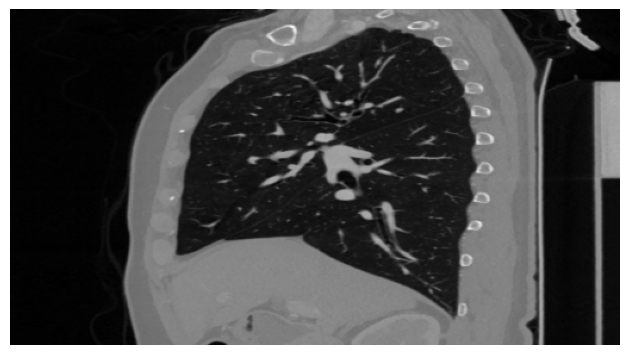

In [ ]:
hdr = img.header
voxel=hdr.get_zooms() #tamaño del voxel
voxel=list(voxel)
img_data = img.get_fdata()


#N=191
mid_slice_x = img_data[N, :, :]
plt.imshow(mid_slice_x.T, cmap='gray', origin='lower') #se utiliza la transpuesta
plt.axis('off')
plt.tight_layout()
plt.show()


**Gaussean filter with kernel 15x15**

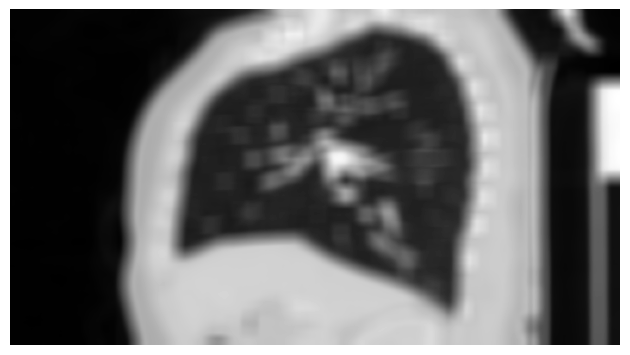

In [ ]:
actual=mid_slice_x.T


if case==1:
    filtrado = cv2.blur(actual,(15,15))
else:
    filtrado = cv2.blur(actual,(9,9))

plt.imshow(filtrado, cmap='gray', origin='lower')
plt.axis('off')
plt.tight_layout()

**HU min and max to get bones**

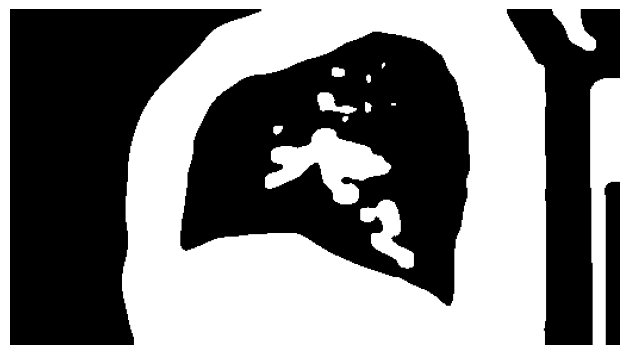

In [ ]:
minim=np.min(filtrado)
minim=-400
maxim=-600
#--------------
n1,m1=np.shape(filtrado)
imagenr=np.zeros((n1,m1))

for i in range(n1):
    for j in range(m1):
        if filtrado[i,j]>=minim and filtrado[i,j]<=maxim:
            imagenr[i,j]=filtrado[i,j]
        elif filtrado[i,j]>=maxim:
            imagenr[i,j]=np.max(filtrado)

plt.axis('off')
plt.tight_layout()
plt.imshow(imagenr, cmap='gray', origin='lower')




**Clean the noise **

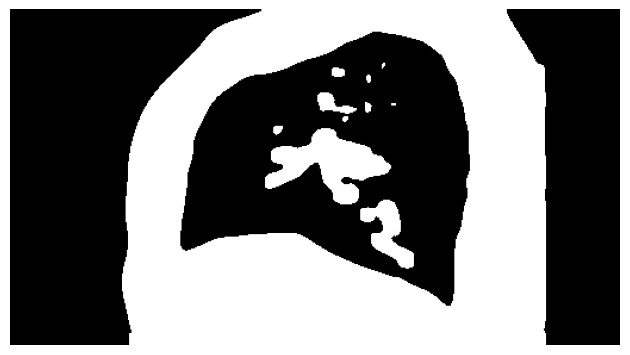

In [ ]:
if case==1:
    imagenr[:,450:]=0
    imagenr[:10,100:450]=np.max(filtrado)
elif case==2:
    imagenr[:10,:]=np.max(filtrado)
elif case==3:
    imagenr[130:160,230:330]=np.max(filtrado)

plt.axis('off')
plt.tight_layout()
plt.imshow(imagenr, cmap='gray', origin='lower')

**Find contours**

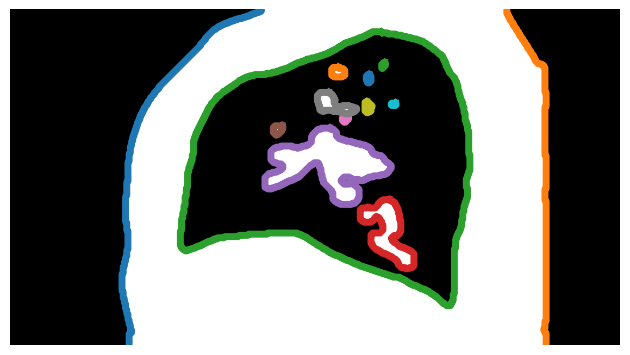

In [ ]:
from skimage import measure
from scipy.spatial import ConvexHull
from sympy import Interval

ff=measure.find_contours(imagenr)

fig, ax = plt.subplots()
ax.imshow(imagenr, cmap=plt.cm.gray, origin='lower')
plt.axis('off')
plt.tight_layout()

for contour in ff:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)



**Find the close contour and discard contours inside of the lung**

In [ ]:
def cont_distance(contour):
    #distance btw the firts point and the last point by pitagoras
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    print("Distancia puntos: ",str(np.sqrt(np.power(dx, 2) + np.power(dy, 2))))
    print("")
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def is_closed(contour):
    if cont_distance(contour) < round(10):
        return True
    else:
        return False


contornos_cuerpo_y_pulmones = []
volumen_contornos = []

aa=1
for contour in ff:
    try:
        hull = ConvexHull(contour,qhull_options="QJ Pp")
    except:
        try:
            print("Error 1---Intentando nuevamente")
            hull = ConvexHull(contour,qhull_options="Qa")
        except:
            print("Error 2---Intentando nuevamente")
            break

    print("Contorno: "+str(aa)+" Volumen: "+str(hull.volume))
    if hull.volume > 1900 and is_closed(contour):
        contornos_cuerpo_y_pulmones.append(contour)
        volumen_contornos.append(hull.volume)

    aa=aa+1

# Discard body contour
if len(contornos_cuerpo_y_pulmones) == 2:
    contornos_cuerpo_y_pulmones=contornos_cuerpo_y_pulmones

elif len(contornos_cuerpo_y_pulmones) > 2:
    if case==1:
        volumen_contornos, contornos_cuerpo_y_pulmones = (list(t) for t in
                zip(*sorted(zip(volumen_contornos, contornos_cuerpo_y_pulmones),reverse=True)))
        contornos_cuerpo_y_pulmones.pop(-1)
    else:
        volumen_contornos, contornos_cuerpo_y_pulmones = (list(t) for t in
                zip(*sorted(zip(volumen_contornos, contornos_cuerpo_y_pulmones))))
        contornos_cuerpo_y_pulmones.pop(-1)

Contorno: 1 Volumen: 11889.999999704021
Distancia puntos:  302.12911147388627

Contorno: 2 Volumen: 3929.999999633861
Distancia puntos:  282.93108701590216

Contorno: 3 Volumen: 42524.000001207154
Distancia puntos:  0.0

Contorno: 4 Volumen: 1611.9999998629603
Contorno: 5 Volumen: 4676.000000889304
Distancia puntos:  0.0

Contorno: 6 Volumen: 48.50000004315899
Contorno: 7 Volumen: 19.500000043344016
Contorno: 8 Volumen: 388.00000014409136
Contorno: 9 Volumen: 41.00000006630191
Contorno: 10 Volumen: 7.500000039007114
Contorno: 11 Volumen: 23.000000017275635
Contorno: 12 Volumen: 79.00000007113331
Contorno: 13 Volumen: 10.500000024330602


**Final Mask**

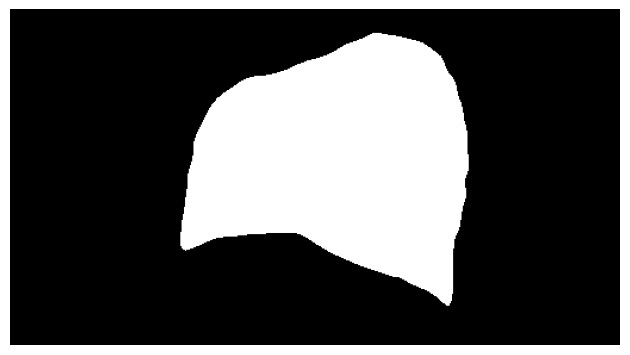

In [ ]:
from PIL import Image, ImageDraw

lung_mask = np.array(Image.new('L',(m1, n1), 0))
for contour in contornos_cuerpo_y_pulmones:
    x = contour[:, 1]
    y = contour[:, 0]
    polygon_tuple = list(zip(x, y))
    img = Image.new('L',  (m1, n1), 0)
    ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
    mask = np.array(img)
    lung_mask += mask

lung_mask[lung_mask > 1] = 1

imxx = cv2.rotate(lung_mask, cv2.ROTATE_90_CLOCKWISE)
imxx = cv2.rotate(imxx, cv2.ROTATE_90_CLOCKWISE)
fp = cv2.flip(imxx,1)

plt.axis('off')
plt.tight_layout()
plt.imshow(fp, cmap='gray')

In [ ]:
#function to define mix btw original and mask

def mix(img1,img2):
    n,m=img1.shape
    aux=np.zeros((n,m))

    for i in range(n):
        for j in range(m):
            if img2[i][j]==1:
                aux[i][j]=img1[i][j]
            else:
                aux[i][j]=np.min(img1)

    return aux


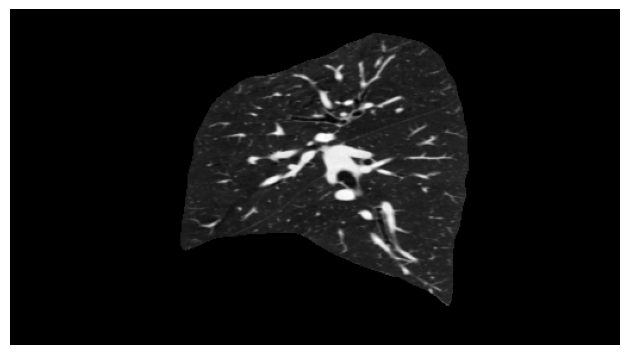

In [ ]:
aux=(aux-np.min(aux))/(np.max(aux)-np.min(aux))
imaggg=mix(aux,fp)
plt.axis('off')
plt.tight_layout()
plt.imshow(imaggg, cmap='gray')